<h1 style='text-align:center; font-size:50px;'>Analysis & Model Testing - Full Workflow</h1>


<br/><br/>
<h2 style='text-align:center; font-size:30px;'>Elplanatory Data Analysis - Full Workflow</h1>
<br/><br/>

## **Part 2: Model Testing Module**
Modules from the `Model Testing` notebook with visual analyses and model evaluation comparisons.

### **Module 1: Library Imports**

Imports data handling, visualization, and machine learning libraries (Pandas, Matplotlib, Seaborn, Scikit-learn, WordCloud).

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import time


### **Module 2: Load Initial and Cleaned Datasets**

Function `load_initial_and_cleaned` loads three datasets (raw and cleaned), ensures numeric target values, removes invalid rows.

In [6]:


# ------------------------------------------------------
# 1. Load Initial and Cleaned Datasets
# ------------------------------------------------------
def load_initial_and_cleaned():
    # Paths for initial (raw) and cleaned datasets
    paths_initial = {
        "Sentiment140": "Sentiment140.csv",
        "Balanced": "balanced_sentiment_dataset.csv",
        "Million": "milliondataset.csv"
    }

    paths_cleaned = {
        "Sentiment140": "Sentiment140_clean.csv",
        "Balanced": "balanced_sentiment_dataset_clean.csv",
        "Million": "milliondataset_clean.csv"
    }

    datasets_initial = {}
    datasets_cleaned = {}

    # Load initial datasets
    for name, path in paths_initial.items():
        try:
            if name == "Sentiment140":
                df = pd.read_csv(path, encoding='latin-1', header=None, usecols=[0,5])
                df.columns = ["target", "Cleaned text"]
                df['target'] = df['target'].replace(4, 1)
            elif name == "Balanced":
                df = pd.read_csv(path, usecols=["text", "sentiment"])
                df = df.rename(columns={"text": "Cleaned text", "sentiment": "target"})
            elif name == "Million":
                df = pd.read_csv(path, usecols=["Text", "Label", "Language"])
                df = df[df["Language"] == "en"]
                df = df[df["Label"].isin(["negative", "positive"])]
                df["target"] = df["Label"].map({"negative": 0, "positive": 1})
                df = df.rename(columns={"Text": "Cleaned text"})
            datasets_initial[name] = df
        except Exception as e:
            print(f"Error loading initial dataset {name}: {e}")

    # Load cleaned datasets
    for name, path in paths_cleaned.items():
        df = pd.read_csv(path, usecols=["Cleaned text", "target"], low_memory=False)
        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        df = df.dropna(subset=['target'])
        df['target'] = df['target'].astype(int)
        df = df.dropna(subset=["Cleaned text"])
        df = df[df["Cleaned text"].str.strip() != ""]
        datasets_cleaned[name] = df

    return datasets_initial, datasets_cleaned




In [7]:
#Load the datasets
datasets_initial, datasets_cleaned = load_initial_and_cleaned()
    

### **Module 3: Text Length Comparison**

Plots side-by-side KDE plots showing word count distribution for raw vs cleaned datasets.

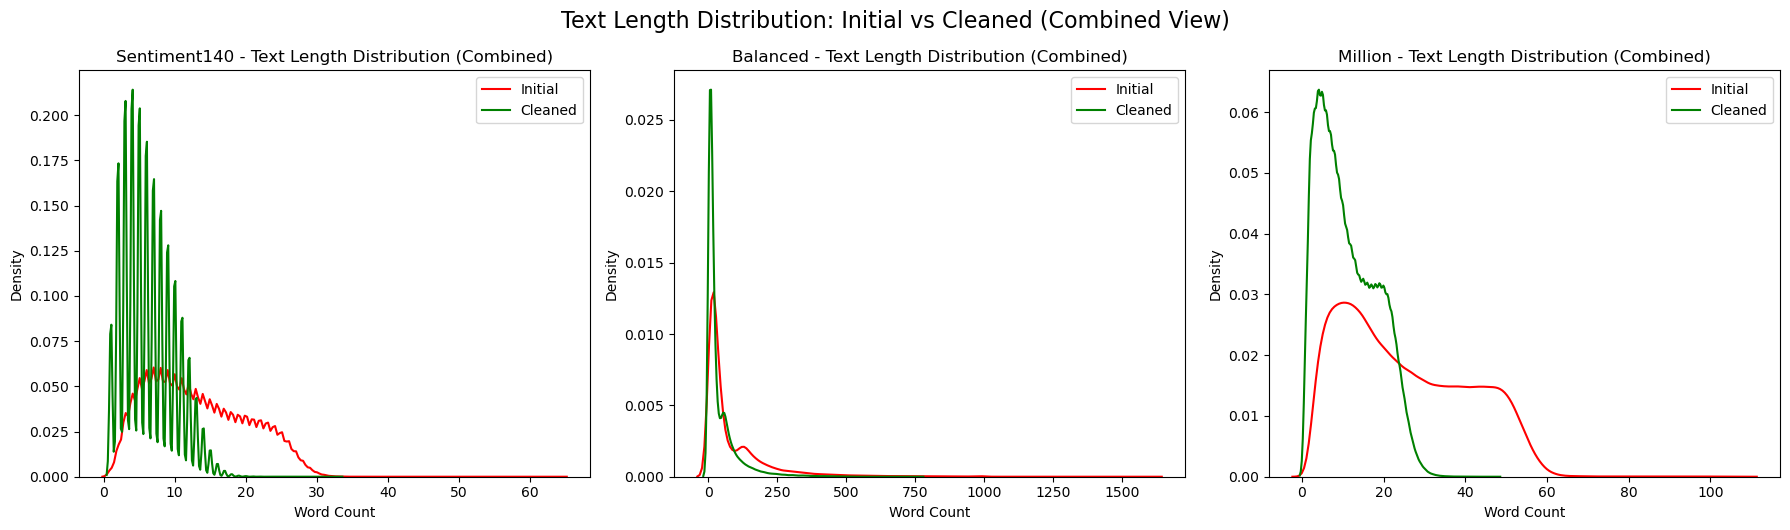

In [22]:
def plot_text_length_combined(datasets_initial, datasets_cleaned):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 datasets in one row

    for idx, name in enumerate(datasets_initial.keys()):
        # Initial dataset lengths
        lengths_initial = datasets_initial[name]["Cleaned text"].dropna().apply(lambda x: len(str(x).split()))
        # Cleaned dataset lengths
        lengths_cleaned = datasets_cleaned[name]["Cleaned text"].apply(lambda x: len(x.split()))

        # Plot both on same axis
        sns.kdeplot(lengths_initial, fill=False, ax=axes[idx], color='red', label='Initial')
        sns.kdeplot(lengths_cleaned, fill=False, ax=axes[idx], color='green', label='Cleaned')

        # Title and labels
        axes[idx].set_title(f"{name} - Text Length Distribution (Combined)")
        axes[idx].set_xlabel("Word Count")
        axes[idx].set_ylabel("Density")
        axes[idx].legend()

    plt.tight_layout()
    plt.suptitle("Text Length Distribution: Initial vs Cleaned (Combined View)", fontsize=16, y=1.05)
    plt.show()

# Call the function
plot_text_length_combined(datasets_initial, datasets_cleaned)


<br/><br/>
### **What this function does: Text Length Distribution (Combined View)**

- Calculates **word counts** for each text in both **Initial** (raw) and **Cleaned** datasets.
- Plots **KDE (density) curves** for both versions **on the same graph**:
  - **Red curve** → Initial text length distribution.
  - **Green curve** → Cleaned text length distribution.
- Arranges three plots side by side for **Sentiment140**, **Balanced**, and **Million** datasets.
- Enables **direct comparison** to see how cleaning impacts text length:
  - Reduction in noise (hashtags, URLs, mentions).
  - Shifts in average word count.
  - Detection of outliers (very long texts in Balanced dataset).

**Purpose in the program:**
- Validates cleaning effectiveness by showing **shorter, more consistent text lengths** post-cleaning.
- Helps determine if additional cleaning or filtering (e.g., removing extreme outliers) is required before modeling.

<br/><br/>

### **Module 4: Class Balance Comparison**

Grouped bar chart comparing positive/negative sentiment counts before and after cleaning.

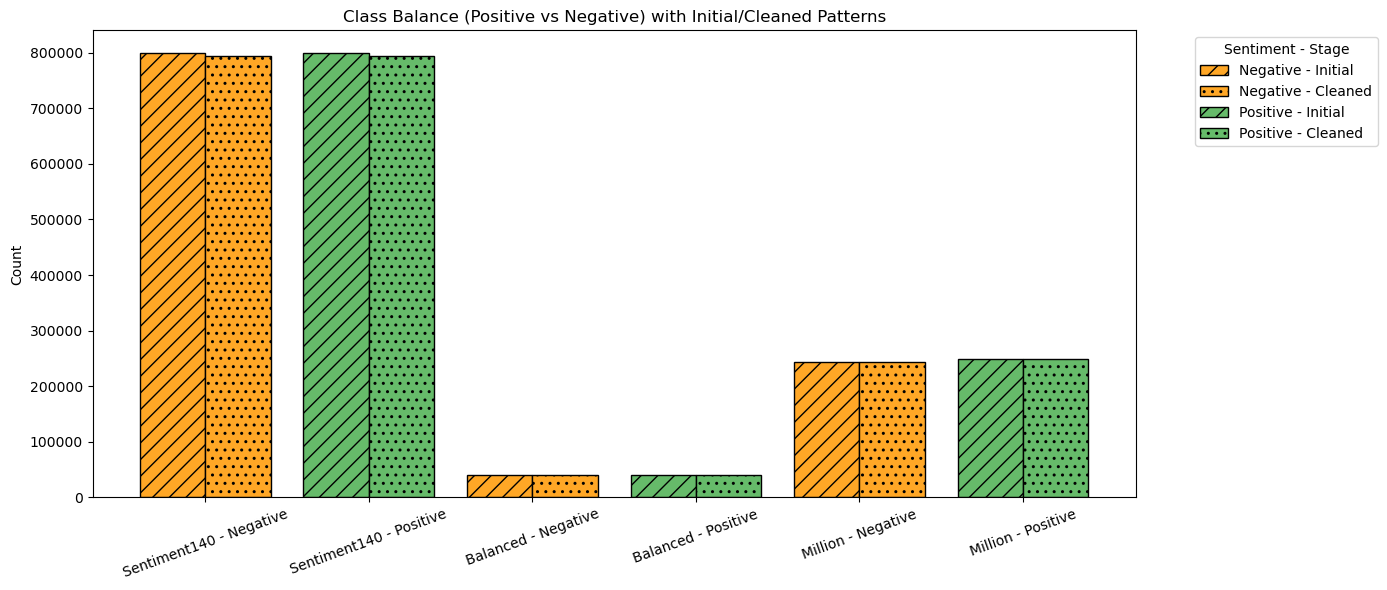

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_balance_pos_neg_patterns(datasets_initial, datasets_cleaned):
    """
    Combined grouped bar chart with:
    - Different colors for Positive vs Negative
    - Different hatch patterns for Initial vs Cleaned
    """
    # Prepare data
    data = []
    for name in datasets_initial.keys():
        init_counts = datasets_initial[name]['target'].value_counts().to_dict()
        clean_counts = datasets_cleaned[name]['target'].value_counts().to_dict()

        # Negative
        data.append([name, 'Negative', 'Initial', init_counts.get(0, 0)])
        data.append([name, 'Negative', 'Cleaned', clean_counts.get(0, 0)])
        # Positive
        data.append([name, 'Positive', 'Initial', init_counts.get(1, 0)])
        data.append([name, 'Positive', 'Cleaned', clean_counts.get(1, 0)])

    df_plot = pd.DataFrame(data, columns=["Dataset", "Sentiment", "Stage", "Count"])
    df_plot["Group"] = df_plot["Dataset"] + " - " + df_plot["Sentiment"]

    # Assign colors: Positive = green, Negative = orange
    sentiment_colors = {'Positive': '#66BB6A', 'Negative': '#FFA726'}

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))

    bar_width = 0.4
    unique_groups = df_plot["Group"].unique()

    offset_map = {'Initial': -bar_width/2, 'Cleaned': bar_width/2}
    hatch_map = {'Initial': '//', 'Cleaned': '..'}

    # Keep track of which labels were added to avoid duplicates
    added_labels = set()

    for i, group in enumerate(unique_groups):
        group_data = df_plot[df_plot["Group"] == group]
        for _, row in group_data.iterrows():
            stage = row["Stage"]
            sentiment = row["Sentiment"]
            label_name = f"{sentiment} - {stage}"

            # Add label only if not already added
            label = label_name if label_name not in added_labels else None
            if label_name not in added_labels:
                added_labels.add(label_name)

            ax.bar(
                i + offset_map[stage],
                row["Count"],
                width=bar_width,
                color=sentiment_colors[sentiment],
                hatch=hatch_map[stage],
                edgecolor='black',
                label=label
            )

    # Axis setup
    ax.set_xticks(range(len(unique_groups)))
    ax.set_xticklabels(unique_groups, rotation=20)
    ax.set_ylabel("Count")
    ax.set_title("Class Balance (Positive vs Negative) with Initial/Cleaned Patterns")

    ax.legend(title="Sentiment - Stage", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


plot_class_balance_pos_neg_patterns(datasets_initial, datasets_cleaned)

<br/><br/>
### **Class Balance (Positive vs Negative) – Initial vs Cleaned**

**What this function does:**
- Plots **grouped bar charts** comparing **positive** and **negative sentiment counts** across datasets.
- Differentiates:
  - **Colors** → Positive (green) vs Negative (orange).
  - **Patterns** → Initial (//) vs Cleaned (..).

**Purpose in the program:**
- Shows whether **cleaning altered the class distribution** (important for balanced modeling).
- Ensures **label integrity** is maintained (positive/negative counts remain consistent).
- Highlights datasets with **imbalances** (e.g., Balanced dataset much smaller vs Sentiment140).

**Key Takeaway:**
- Cleaning process did **not significantly affect sentiment ratios**.
- Sentiment140 dominates in volume, while Balanced and Million datasets are relatively smaller.
<br/><br/>

### **Module 5: Vocabulary Richness (TTR)**

Compares type-token ratio (unique/total words) between raw and cleaned datasets.


Vocabulary Richness Comparison:
         Dataset    Stage  Total Words  Unique Words     TTR
0  Sentiment140  Initial     21081841       1350598  0.0641
1      Balanced  Initial      7008144        376103  0.0537
2       Million  Initial     12473021       1033783  0.0829
3  Sentiment140  Cleaned     10015741        401011  0.0400
4      Balanced  Cleaned      3231030        138097  0.0427
5       Million  Cleaned      5520694        182900  0.0331


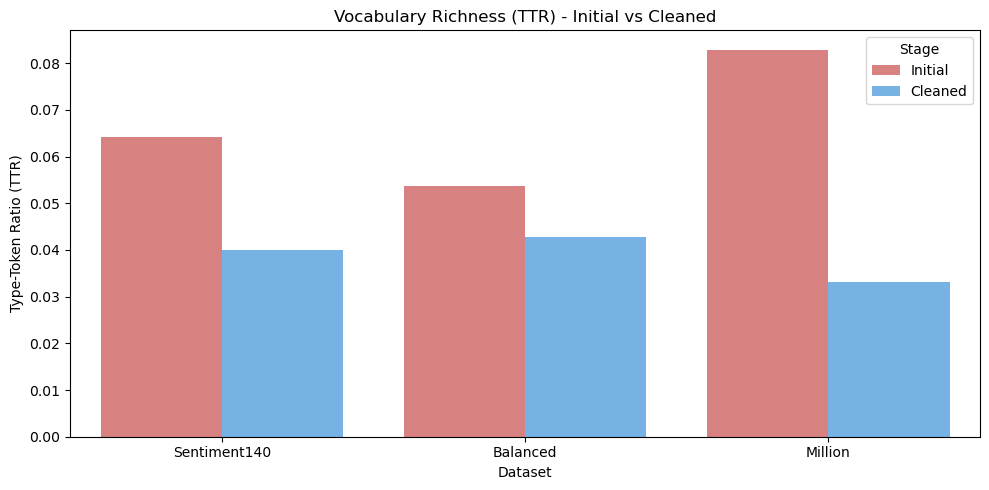

In [24]:
def plot_vocabulary_richness_comparison(datasets_initial, datasets_cleaned):
    """
    Compare vocabulary richness (Type-Token Ratio) between initial and cleaned datasets
    for all datasets side by side.
    """
    richness_data = []

    # Calculate TTR for initial and cleaned datasets
    for stage_name, datasets in [("Initial", datasets_initial), ("Cleaned", datasets_cleaned)]:
        for name, df in datasets.items():
            words = " ".join(df["Cleaned text"]).split()
            total_words = len(words)
            unique_words = len(set(words))
            ttr = unique_words / total_words if total_words > 0 else 0
            richness_data.append([name, stage_name, total_words, unique_words, round(ttr, 4)])

    # Create DataFrame
    richness_df = pd.DataFrame(
        richness_data, columns=["Dataset", "Stage", "Total Words", "Unique Words", "TTR"]
    )

    print("\nVocabulary Richness Comparison:\n", richness_df)

    # Plot side-by-side bar chart for TTR
    plt.figure(figsize=(10, 5))
    sns.barplot(data=richness_df, x="Dataset", y="TTR", hue="Stage", palette=["#E57373", "#64B5F6"])
    plt.title("Vocabulary Richness (TTR) - Initial vs Cleaned")
    plt.ylabel("Type-Token Ratio (TTR)")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()

plot_vocabulary_richness_comparison(datasets_initial, datasets_cleaned)

<br/><br/>
### **Vocabulary Richness Comparison (Type-Token Ratio)**

**Purpose of the Function:**
- Evaluates **vocabulary diversity** in datasets using **Type-Token Ratio (TTR)**:
  - **TTR = Unique Words / Total Words**
  - Indicates how rich or repetitive the language is.

**What this function does:**
1. Combines all texts in each dataset (Initial and Cleaned).
2. Counts:
   - **Total Words** → Total tokens after preprocessing.
   - **Unique Words** → Distinct tokens used.
3. Calculates **TTR** for each dataset stage (Initial vs Cleaned).
4. Displays:
   - **Table**: Exact numerical values (Total Words, Unique Words, TTR).
   - **Bar Chart**: Visual comparison of TTR between stages.

---

#### **About the Table**

The table lists five key columns:

- **Dataset**: The dataset being analyzed (Sentiment140, Balanced, Million).  
- **Stage**: Indicates whether the data is **Initial (raw)** or **Cleaned**.  
- **Total Words**: Total number of tokens present in the dataset (after preprocessing for that stage).  
- **Unique Words**: Number of distinct tokens present in the dataset.  
- **TTR (Type-Token Ratio)**: A measure of vocabulary richness calculated as `Unique Words ÷ Total Words`.

**Example Insights from Table:**
- **Sentiment140 Initial vs Cleaned**:  
  - Initial: 21,081,841 total words with 1,350,598 unique words → TTR = 0.0641  
  - Cleaned: 10,015,741 total words with 401,011 unique words → TTR = 0.0400  
  - Cleaning roughly halved total words and significantly reduced unique words, lowering TTR.

- **Balanced Dataset**:  
  - Similar drop from TTR ≈ 0.0537 to 0.0427 after cleaning.

- **Million Dataset**:  
  - Largest drop in TTR (0.0829 → 0.0331) showing heavy noise removal and vocabulary reduction.

---

**Why this matters:**
- Lower TTR after cleaning indicates removal of noisy and rare tokens.
- Important for **feature extraction** (Count/TF-IDF) to reduce sparsity and improve model generalization.

<br/><br/>

### **Module 6: Noise Analysis (URLs, Mentions, Hashtags)**

Counts and compares noise elements between raw and cleaned datasets.


Noise Elements Comparison:
         Dataset    Stage    URLs  Mentions  Hashtags
0  Sentiment140  Initial   71635    798682     45380
1      Balanced  Initial   16301     14708     22647
2       Million  Initial  161472    596577    154957
3  Sentiment140  Cleaned      29         0         0
4      Balanced  Cleaned       3         0         0
5       Million  Cleaned       1         0         0


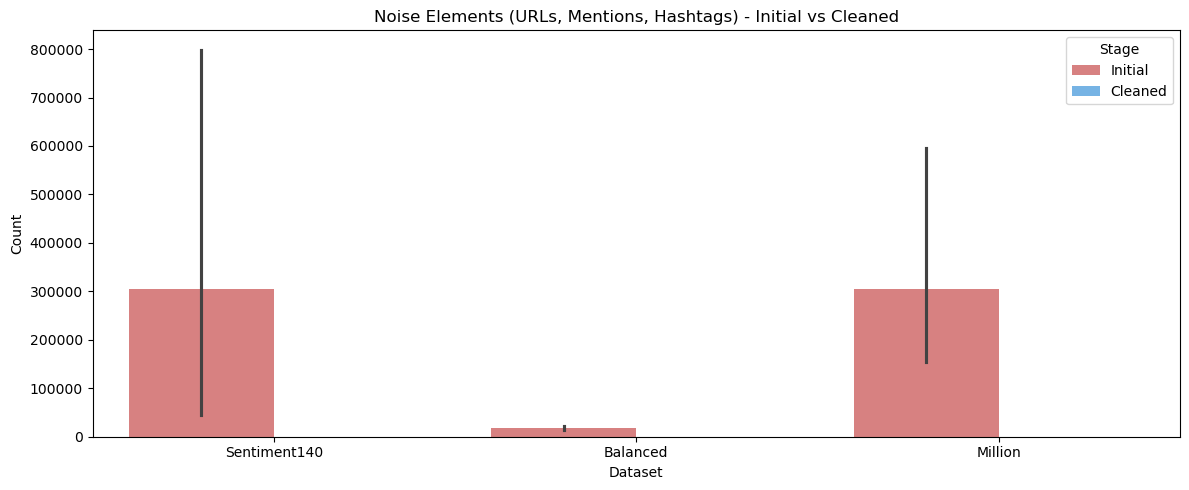

In [25]:
def plot_noise_analysis_comparison(datasets_initial, datasets_cleaned):
    """
    Compare noise elements (URLs, mentions, hashtags) between initial and cleaned datasets
    for all datasets in a grouped bar chart.
    """
    noise_counts = []

    # Calculate noise for initial and cleaned
    for stage_name, datasets in [("Initial", datasets_initial), ("Cleaned", datasets_cleaned)]:
        for name, df in datasets.items():
            urls = df["Cleaned text"].str.count(r"http").sum()
            mentions = df["Cleaned text"].str.count(r"@").sum()
            hashtags = df["Cleaned text"].str.count(r"#").sum()
            noise_counts.append([name, stage_name, urls, mentions, hashtags])

    # Convert to DataFrame
    noise_df = pd.DataFrame(noise_counts, columns=["Dataset", "Stage", "URLs", "Mentions", "Hashtags"])

    print("\nNoise Elements Comparison:\n", noise_df)

    # Melt for plotting
    noise_melted = noise_df.melt(id_vars=["Dataset", "Stage"], var_name="Element", value_name="Count")

    # Plot
    plt.figure(figsize=(12, 5))
    sns.barplot(data=noise_melted, x="Dataset", y="Count", hue="Stage", palette=["#E57373", "#64B5F6"])
    plt.title("Noise Elements (URLs, Mentions, Hashtags) - Initial vs Cleaned")
    plt.ylabel("Count")
    plt.xlabel("Dataset")
    plt.legend(title="Stage")
    plt.tight_layout()
    plt.show()


plot_noise_analysis_comparison(datasets_initial, datasets_cleaned)

### **Noise Elements Comparison (URLs, Mentions, Hashtags)**

**Purpose of the Function:**
- Quantifies noisy elements like URLs, mentions (@), and hashtags (#) in texts.
- Confirms cleaning effectively removes social media artifacts.

**What this function does:**
1. Counts occurrences of URLs, mentions, and hashtags in each dataset.
2. Compares counts for Initial vs Cleaned datasets.
3. Plots grouped bar chart for visual comparison.

**About the Table/Chart:**
- Table (printed) shows exact counts of each noise element.
- Bar chart visually confirms dramatic drop post-cleaning.

**Key Insight:**
- Noise elements nearly eliminated in Cleaned datasets — validating preprocessing effectiveness.


### **Module 7: Punctuation Analysis**

Compares average punctuation ratio between raw and cleaned datasets.


Punctuation Ratio Comparison:
         Dataset    Stage  Avg Punctuation Ratio
0  Sentiment140  Initial               0.031935
1      Balanced  Initial               0.024172
2       Million  Initial               0.018608
3  Sentiment140  Cleaned               0.000000
4      Balanced  Cleaned               0.000000
5       Million  Cleaned               0.000000


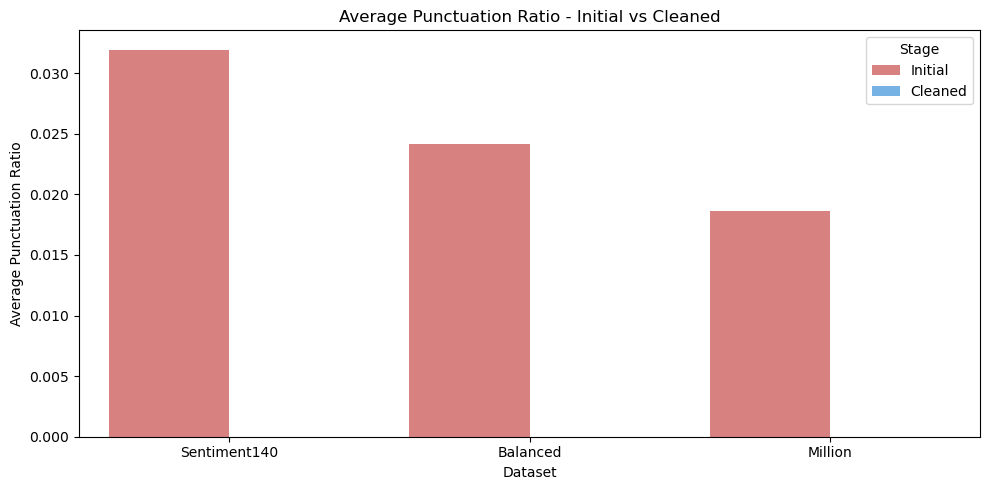

In [8]:
def plot_punctuation_analysis_comparison(datasets_initial, datasets_cleaned):
    """
    Compare average punctuation ratio between initial and cleaned datasets.
    """
    punct_data = []

    # Compute punctuation ratio for initial and cleaned
    for stage_name, datasets in [("Initial", datasets_initial), ("Cleaned", datasets_cleaned)]:
        for name, df in datasets.items():
            punct_ratio = df["Cleaned text"].apply(
                lambda x: sum(1 for c in x if c in "!?.,") / max(len(x), 1)
            ).mean()
            punct_data.append([name, stage_name, punct_ratio])

    # Convert to DataFrame
    punct_df = pd.DataFrame(punct_data, columns=["Dataset", "Stage", "Avg Punctuation Ratio"])

    print("\nPunctuation Ratio Comparison:\n", punct_df)

    # Plot grouped bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(data=punct_df, x="Dataset", y="Avg Punctuation Ratio", hue="Stage", palette=["#E57373", "#64B5F6"])
    plt.title("Average Punctuation Ratio - Initial vs Cleaned")
    plt.ylabel("Average Punctuation Ratio")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()

plot_punctuation_analysis_comparison(datasets_initial, datasets_cleaned)

### **Average Punctuation Ratio Comparison**

**Purpose of the Function:**
- Measures proportion of punctuation in texts before vs after cleaning.
- Validates if punctuation removal (commas, exclamation marks, etc.) was effective.

**What this function does:**
1. Calculates punctuation ratio = (punctuation characters ÷ total characters) for each text.
2. Averages ratios per dataset (Initial & Cleaned).
3. Plots grouped bar chart for comparison.

**About the Chart:**
- Shows significant reduction in punctuation ratio post-cleaning.

**Key Insight:**
- Confirms punctuation removal step worked.
- Reduced punctuation leads to cleaner features for vectorization.


### **Module 8: Word Clouds (Positive vs Negative)**

Generates sentiment-specific word clouds from cleaned datasets.

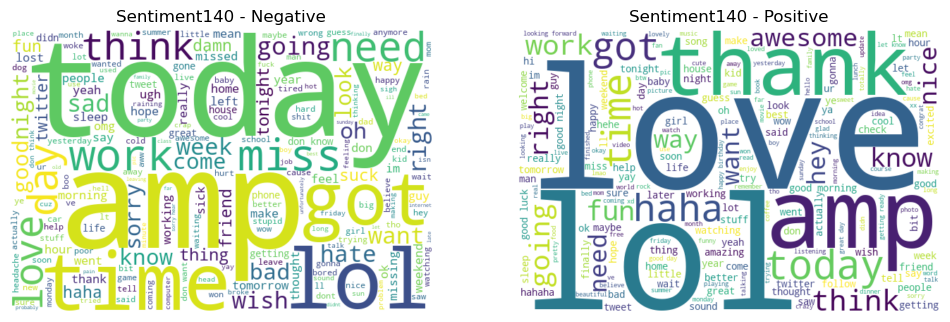

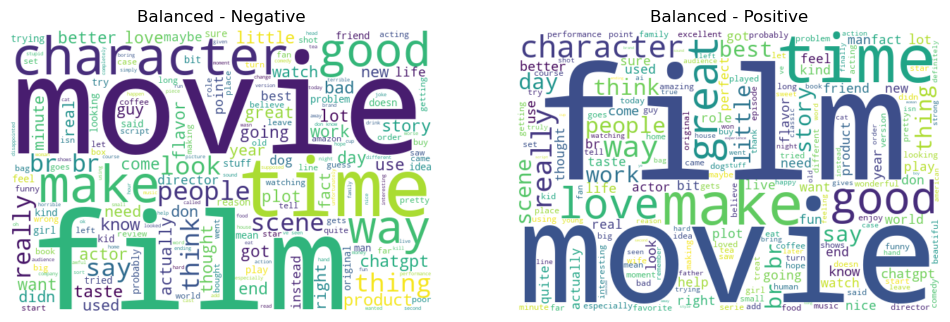

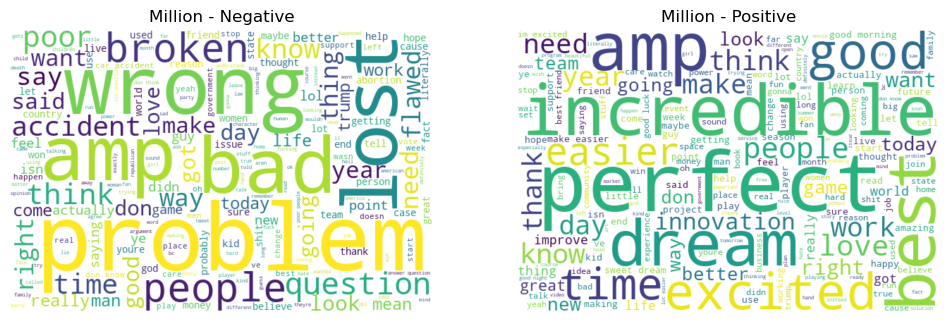

In [9]:
# ------------------------
# 7. Word clouds (positive vs negative) for Cleaned Datasets
# ------------------------
def plot_wordclouds(datasets):
    for name, df in datasets.items():
        plt.figure(figsize=(12, 5))
        for idx, sentiment in enumerate([0, 1]):
            text = " ".join(df[df['target'] == sentiment]["Cleaned text"])
            wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
            plt.subplot(1, 2, idx+1)
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"{name} - {'Negative' if sentiment==0 else 'Positive'}")
        plt.show()

plot_wordclouds(datasets_cleaned)

### **Word Clouds by Sentiment**

**Purpose of the Function:**
- Visualizes most frequent words in **Positive** and **Negative** texts separately.
- Highlights sentiment-associated terms.

**What this function does:**
1. Generates two word clouds per dataset:
   - Negative words (left)
   - Positive words (right)
2. Uses color size to indicate frequency.

**About the Chart:**
- Shows common sentiment cues:
  - Positive: love, good, great
  - Negative: bad, work, wrong

**Key Insight:**
- Provides qualitative understanding of sentiment vocabulary.
- Confirms alignment with expectations (positive vs negative cues).


### **Module 9: Summary Report**

Provides summary metrics (total texts, avg words per text) comparing raw vs cleaned datasets.


Summary Report Comparison:
         Dataset    Stage  Total Texts  Avg Words per Text
0  Sentiment140  Initial      1600000               13.18
1      Balanced  Initial        80000               87.60
2       Million  Initial       492662               25.32
3  Sentiment140  Cleaned      1588560                6.30
4      Balanced  Cleaned        79827               40.48
5       Million  Cleaned       492501               11.21


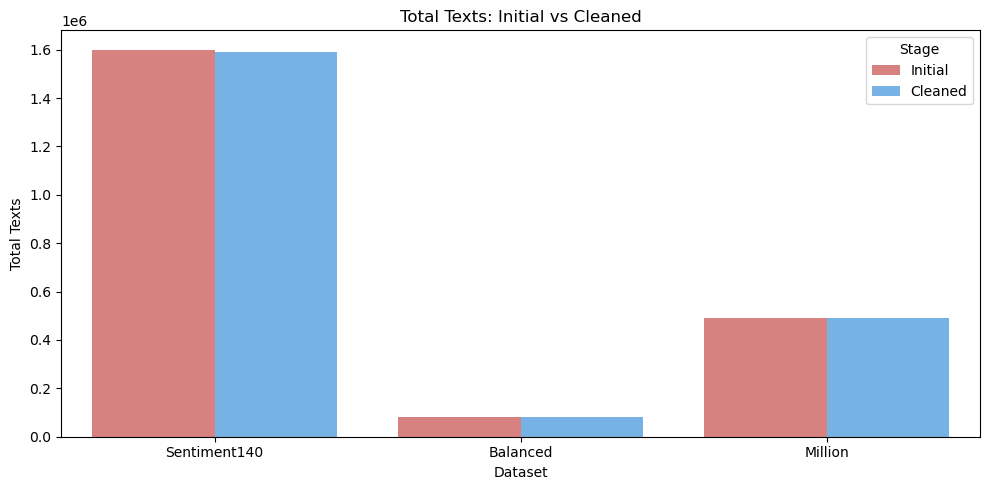

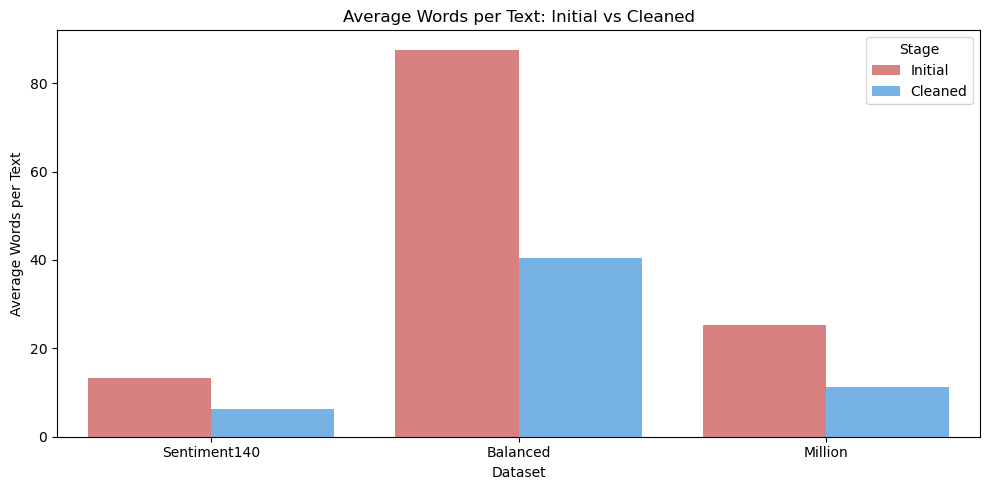

,Dataset,Stage,Total Texts,Avg Words per Text
0,Sentiment140,Initial,1600000,13.18
1,Balanced,Initial,80000,87.60
2,Million,Initial,492662,25.32
3,Sentiment140,Cleaned,1588560,6.30
4,Balanced,Cleaned,79827,40.48
5,Million,Cleaned,492501,11.21


In [26]:
def generate_summary_report_comparison(datasets_initial, datasets_cleaned):
    """
    Generate summary comparing Initial vs Cleaned datasets:
    - Total Texts
    - Average Words per Text
    """
    summary = []

    # Compute stats for both stages
    for stage_name, datasets in [("Initial", datasets_initial), ("Cleaned", datasets_cleaned)]:
        for name, df in datasets.items():
            avg_len = df["Cleaned text"].apply(lambda x: len(x.split())).mean()
            summary.append([name, stage_name, len(df), round(avg_len, 2)])

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary, columns=["Dataset", "Stage", "Total Texts", "Avg Words per Text"])

    print("\nSummary Report Comparison:\n", summary_df)

    # Plot grouped bar chart for Total Texts
    plt.figure(figsize=(10, 5))
    sns.barplot(data=summary_df, x="Dataset", y="Total Texts", hue="Stage", palette=["#E57373", "#64B5F6"])
    plt.title("Total Texts: Initial vs Cleaned")
    plt.ylabel("Total Texts")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()

    # Plot grouped bar chart for Avg Words per Text
    plt.figure(figsize=(10, 5))
    sns.barplot(data=summary_df, x="Dataset", y="Avg Words per Text", hue="Stage", palette=["#E57373", "#64B5F6"])
    plt.title("Average Words per Text: Initial vs Cleaned")
    plt.ylabel("Average Words per Text")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()

    return summary_df

generate_summary_report_comparison(datasets_initial, datasets_cleaned)

### **Summary Report – Initial vs Cleaned**

**Purpose of the Function:**
- Provides overall summary metrics of dataset changes post-cleaning.

**What this function does:**
1. Calculates:
   - Total texts
   - Average words per text
2. Creates **summary table** and **two bar charts**:
   - Total texts (Initial vs Cleaned)
   - Avg words per text (Initial vs Cleaned)

**About the Table:**
- Shows exact dataset size reduction and word length changes.
- Example: Million dataset drops from 12M words to 5.5M words after cleaning.

**Key Insight:**
- Confirms cleaning reduces data size and average word count significantly.
- Provides quick overview of preprocessing impact across datasets.


### **Module 10: Top 20 Words Frequency and Compare with Other Dataset**

It Highlights
 - Words common in both positive and negative sentiments[**Blue Color**]
 - Differences in frequency distribution across datasets.[**Orange Color**]



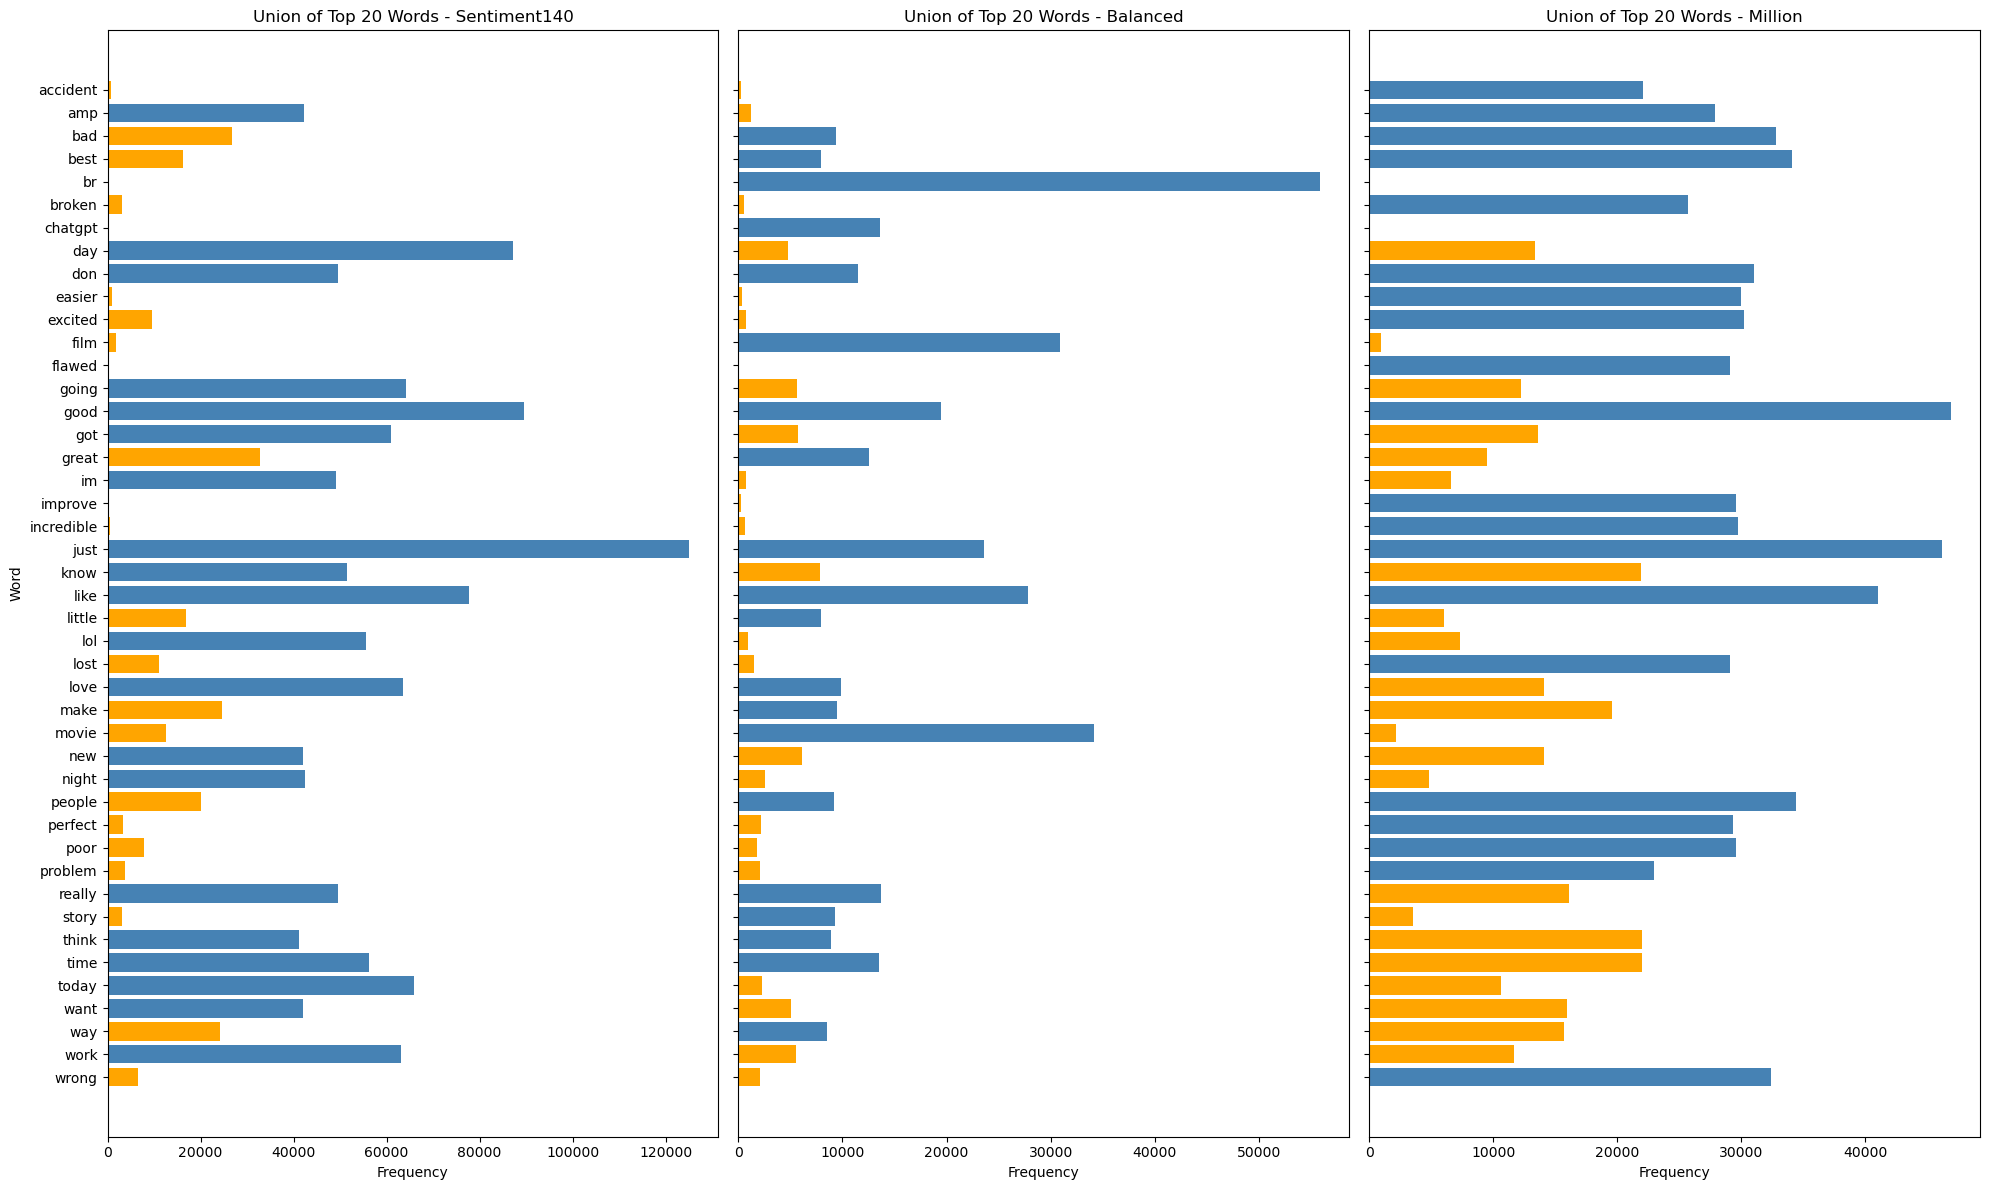

In [11]:

def get_top_words(df, column="Cleaned text", top_n=20):
    all_words = " ".join(df[column].astype(str)).split()
    word_counts = Counter(all_words)
    return pd.DataFrame(word_counts.most_common(top_n), columns=["Word", "Frequency"])

# -------------------
# 2. Create union of top words across datasets
# -------------------
# Get top 20 per dataset
top_words_results = {}
full_word_counts = {}

for name, df in datasets_cleaned.items():
    df = df.dropna(subset=["Cleaned text"])
    
    # Full frequency for ALL words
    full_counts = Counter(" ".join(df["Cleaned text"].astype(str)).split())
    full_word_counts[name] = full_counts
    
    # Top 20 words
    top_words_results[name] = get_top_words(df)

# Union of top 20 words from all datasets
union_top_words = sorted(set().union(*[set(df["Word"]) for df in top_words_results.values()]))

# -------------------
# 3. Prepare aligned data: frequencies + color coding
# -------------------
aligned_data = {}
for name in datasets_cleaned.keys():
    top_words_set = set(top_words_results[name]["Word"])
    freq_map = full_word_counts[name]  # use full counts to get frequency even if not top 20
    
    data_for_plot = []
    for word in union_top_words:
        freq = freq_map.get(word, 0)  # frequency (0 if not present at all)
        color = "steelblue" if word in top_words_set else "orange"  # Blue = top 20, Orange = not top 20
        data_for_plot.append((word, freq, color))
    
    aligned_data[name] = data_for_plot

# -------------------
# 4. Plot
# -------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 12), sharey=True)

for idx, (name, data) in enumerate(aligned_data.items()):
    words = [x[0] for x in data]
    freqs = [x[1] for x in data]
    colors = [x[2] for x in data]

    axes[idx].barh(words, freqs, color=colors)
    axes[idx].invert_yaxis()
    axes[idx].set_title(f"Union of Top 20 Words - {name}")
    axes[idx].set_xlabel("Frequency")
    if idx == 0:
        axes[idx].set_ylabel("Word")

plt.tight_layout()
plt.show()


### Module 11: **Union of Top 20 Words Across Datasets**

**Purpose:**  
Compares top 20 frequent words from Sentiment140, Balanced, and Million datasets to reveal shared vs. dataset-specific vocabulary, aiding cross-dataset feature understanding.

**What it does:**  
- Extracts top 20 words per dataset.  
- Creates a union of all these words.  
- Plots frequencies for each dataset:  
  - **Blue** = word is top 20 in current dataset.  
  - **Orange** = word is top 20 elsewhere but not here.  

**About the Chart/Table:**  
- Three horizontal bar charts (one per dataset).  
- X-axis: word frequency; Y-axis: union of top 20 words.  
- Highlights overlap (blue) and vocabulary gaps (orange).

**Insights:**  
- Shared words like *just, good, like* dominate across datasets.  
- Balanced dataset has unique slang (*chatgpt, br*).  
- Sentiment140 shows conversational words (*day, going, time*).  
- Million dataset emphasizes polar words (*great, bad, perfect*).  
- Orange bars reveal words valuable for **cross-dataset modeling** but underrepresented in some datasets.


### Purpose
To compare frequently used words by sentiment within each dataset.
 - Provide quantitative (table) + visual (donut) perspectives
   - **Donut** = quick sentiment overview
   - **Table** = exact counts for analysis.

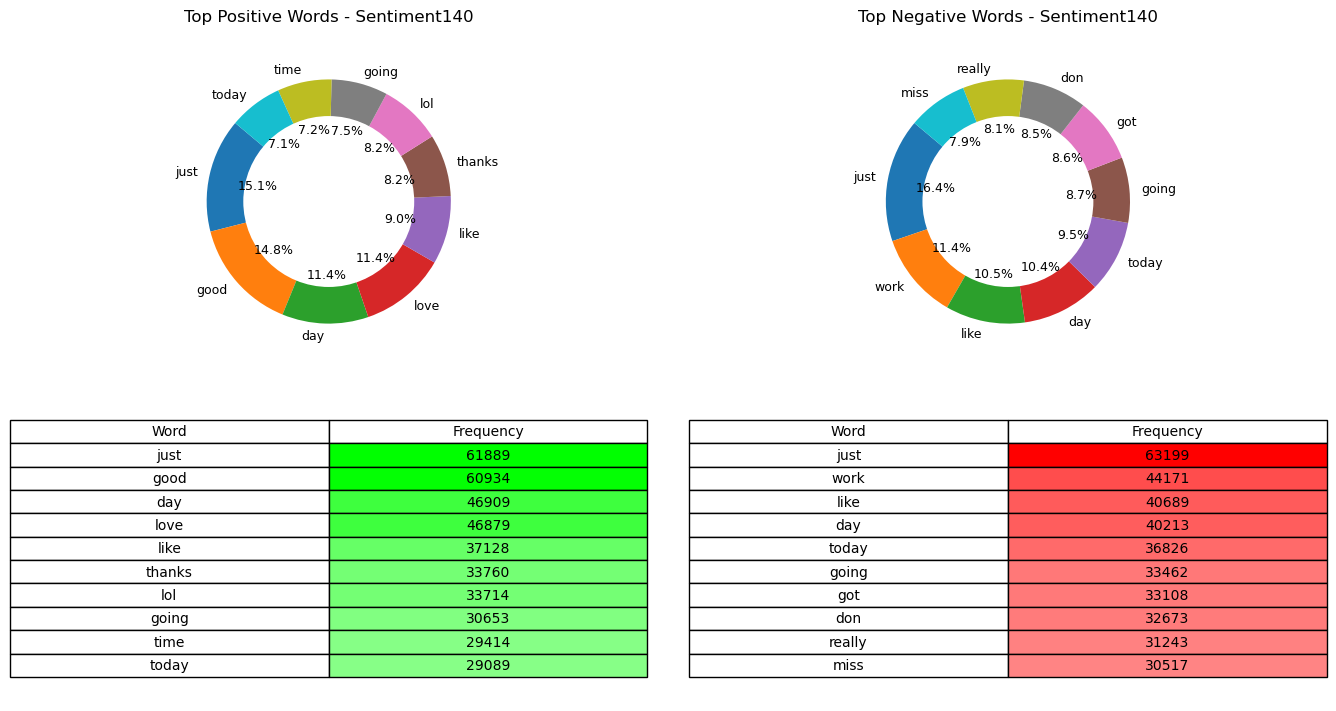

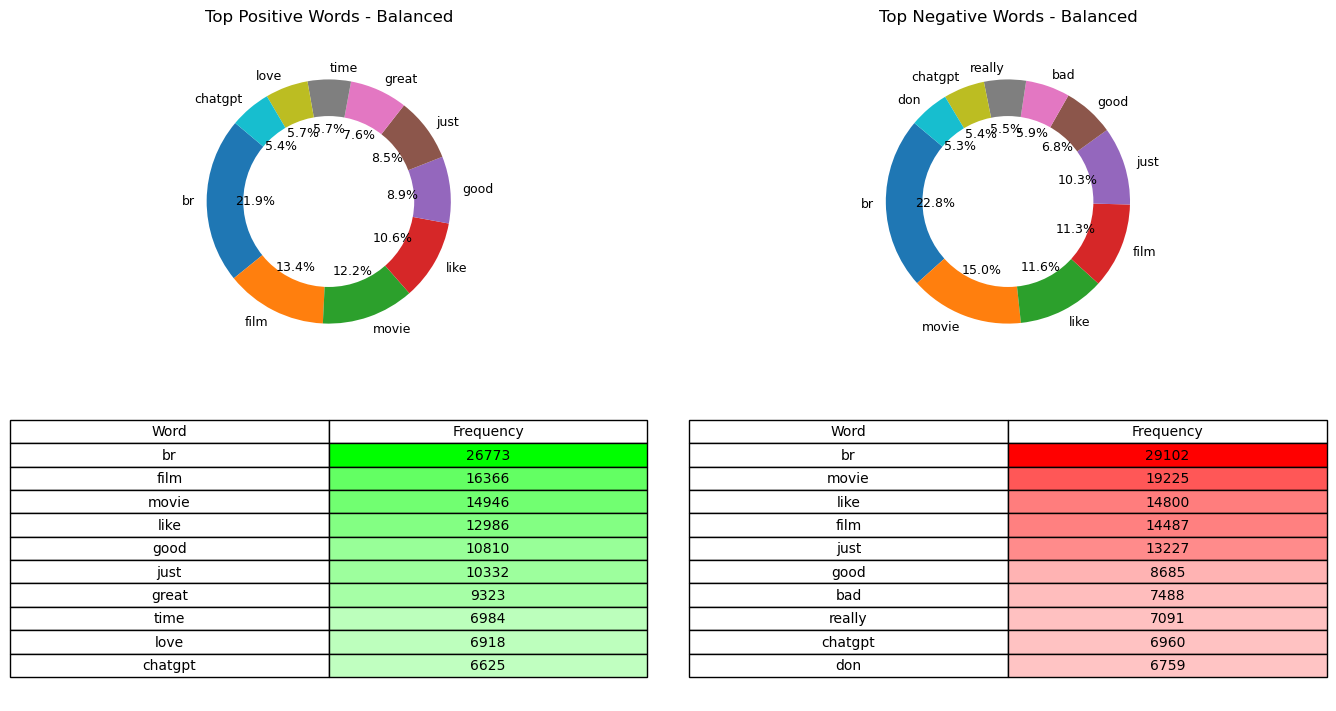

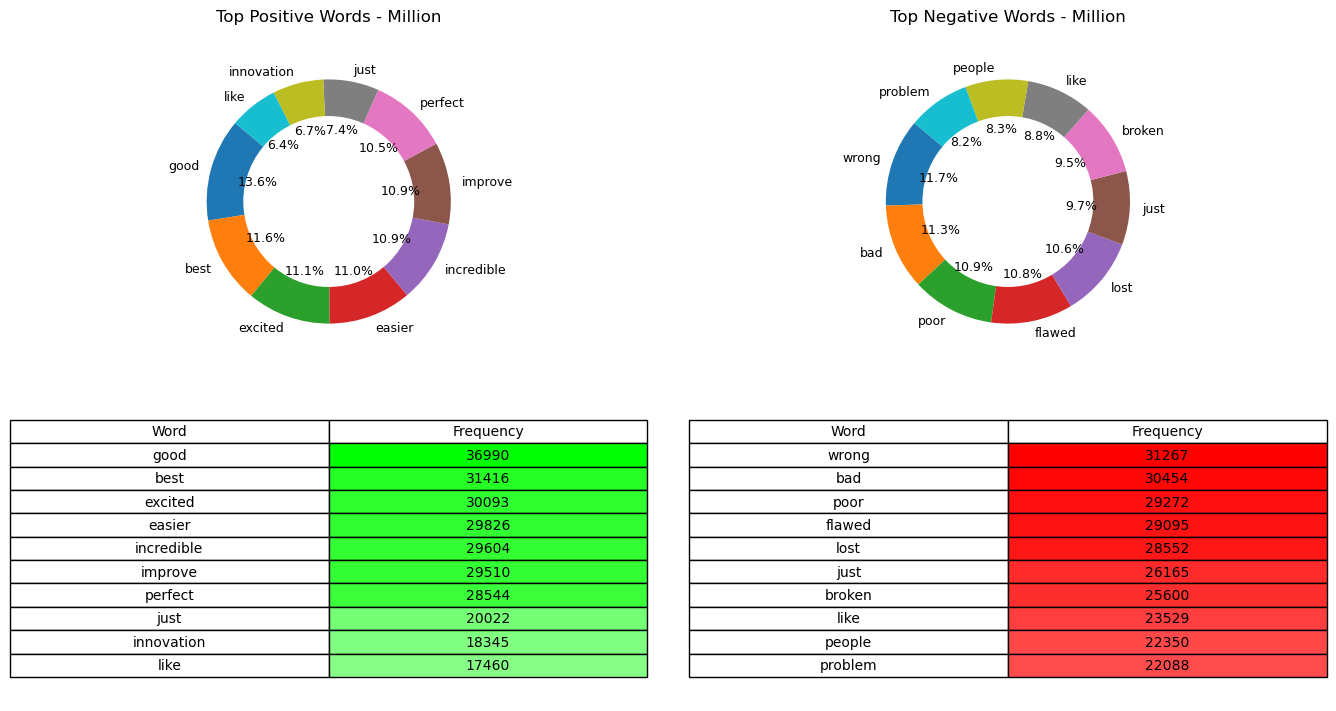

In [12]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# -------------------
# 1. Get top words by sentiment
# -------------------
def get_top_words_by_sentiment(df, sentiment, column="Cleaned text", target_col="target", top_n=10):
    subset = df[df[target_col] == sentiment]
    all_words = " ".join(subset[column].astype(str)).split()
    word_counts = Counter(all_words)
    return pd.DataFrame(word_counts.most_common(top_n), columns=["Word", "Frequency"])

# -------------------
# 2. Plot donut with table (top 10 words, fixed labels)
# -------------------
def plot_donut_with_table(pos_df, neg_df, dataset_name):
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[3, 3, 1.8])  # Adjust height ratios for better spacing

    # ---- Positive Donut ----
    ax_pos = fig.add_subplot(gs[0, 0])
    wedges, texts, autotexts = ax_pos.pie(
        pos_df["Frequency"],
        labels=pos_df["Word"],
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9}
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax_pos.add_artist(centre_circle)
    ax_pos.set_title(f"Top Positive Words - {dataset_name}", pad=20)

    # ---- Negative Donut ----
    ax_neg = fig.add_subplot(gs[0, 1])
    wedges, texts, autotexts = ax_neg.pie(
        neg_df["Frequency"],
        labels=neg_df["Word"],
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9}
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax_neg.add_artist(centre_circle)
    ax_neg.set_title(f"Top Negative Words - {dataset_name}", pad=20)

    # ---- Positive Table ----
    ax_table_pos = fig.add_subplot(gs[1, 0])
    ax_table_pos.axis('off')
    pos_table = ax_table_pos.table(
        cellText=pos_df.values,
        colLabels=pos_df.columns,
        loc='center',
        cellLoc='center'
    )
    pos_table.auto_set_font_size(False)
    pos_table.set_fontsize(10)
    pos_table.scale(1, 1.2)

    # Apply green gradient to Positive
    max_val_pos = pos_df["Frequency"].max()
    for i, freq in enumerate(pos_df["Frequency"]):
        color_intensity = freq / max_val_pos
        pos_table[(i+1, 1)].set_facecolor((1-color_intensity, 1, 1-color_intensity))

    # ---- Negative Table ----
    ax_table_neg = fig.add_subplot(gs[1, 1])
    ax_table_neg.axis('off')
    neg_table = ax_table_neg.table(
        cellText=neg_df.values,
        colLabels=neg_df.columns,
        loc='center',
        cellLoc='center'
    )
    neg_table.auto_set_font_size(False)
    neg_table.set_fontsize(10)
    neg_table.scale(1, 1.2)

    # Apply red gradient to Negative
    max_val_neg = neg_df["Frequency"].max()
    for i, freq in enumerate(neg_df["Frequency"]):
        color_intensity = freq / max_val_neg
        neg_table[(i+1, 1)].set_facecolor((1, 1-color_intensity, 1-color_intensity))

    plt.tight_layout(pad=3)  # Extra padding to avoid overlap
    plt.show()

# -------------------
# 3. Generate donut + table for each dataset
# -------------------
for name, df in datasets_cleaned.items():
    df = df.dropna(subset=["Cleaned text", "target"])

    top_pos = get_top_words_by_sentiment(df, sentiment=1)
    top_neg = get_top_words_by_sentiment(df, sentiment=0)

    plot_donut_with_table(top_pos, top_neg, name)


### **Top 20 Words Frequency Comparison**

**Purpose of the Function:**
- Compares frequency of top 20 words across datasets (positive vs negative).

**What this function does:**
1. Identifies union of top 20 words per sentiment.
2. Plots grouped horizontal bars:
   - Blue = Positive
   - Orange = Negative
3. Side-by-side panels for each dataset (Sentiment140, Balanced, Million).

**About the Chart:**
- Shows overlap and differences in sentiment-related vocabulary.
- Highlights dataset-specific slang (e.g., "chatgpt", "br" in Balanced).

**Key Insight:**
- Reveals shared sentiment words (just, good, like) and dataset-specific noise.
- Helps refine stopword lists or custom cleaning rules.



<br/><br/>
<h2 style='text-align:center; font-size:30px;'>Part 3: Model Testing - Full Workflow</h2>
<br/><br/>


### **Module 1: Define Model Name and Vectorization**



In [8]:
# -------------------
# Models and Vectorizers
# -------------------
vectorizers = {
    'Count': CountVectorizer(max_features=50000),
    'TF-IDF': TfidfVectorizer(max_features=50000)
}

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVC': LinearSVC()
}


### **Module 2: Load the Dataset**
 - **Base Model** : *Sentiment140*
 - **Test Model** : *Balanced*
 - **Test Model** : *Million*

In [9]:
#Dataset Selection from : datasets_cleaned = {}
#       "Sentiment140": "Sentiment140_clean.csv",
#        "Balanced": "balanced_sentiment_dataset_clean.csv",
#        "Million": "milliondataset_clean.csv"
# ----------------------------------------------------------------
# 1. Train on Sentiment140
# ----------------------------------------------------------------
train_df = datasets_cleaned["Sentiment140"]
X_train = train_df["Cleaned text"]
y_train = train_df["target"]

# ----------------------------------------------------------------
# 2. Test on Balanced and Million datasets
# ----------------------------------------------------------------
test_sets = {
    "Balanced": datasets_cleaned["Balanced"],
    "Million": datasets_cleaned["Million"]
}


### **Module 3: Build Model and Cross Validate**
 - Build Model : Sentiment140
 - Test Model : Balanced and Million
 - Test The **Accuracy** and **Classification**

In [22]:
# -------------------
# 3. Train models and evaluate on test sets
# -------------------
results = []
conf_matrices = {}

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model)
        ])

        # Train and test on each dataset
        for test_name, test_df in test_sets.items():
            X_test = test_df["Cleaned text"]
            y_test = test_df["target"]
            
            start_time = time.time()
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            end_time = time.time()
            elapsed_time = round(end_time - start_time, 2)

            acc = round(accuracy_score(y_test, y_pred), 4)
            cm = confusion_matrix(y_test, y_pred)
            # Store it using model + dataset as key
            conf_matrices[f"{model_name} ({vec_name}) - {test_name}"] = cm
            results.append({
                'Model': f"{model_name} ({vec_name})",
                'Test Dataset': test_name,
                'Accuracy': acc,
                'Execution Time (s)': elapsed_time
            })

            print(f"\n=== Classification Report for {model_name} ({vec_name}) on {test_name} Dataset ===")
            print(classification_report(y_test, y_pred, digits=4))



=== Classification Report for Logistic Regression (Count) on Balanced Dataset ===
              precision    recall  f1-score   support

           0     0.7596    0.6204    0.6830     39902
           1     0.6794    0.8038    0.7363     39925

    accuracy                         0.7121     79827
   macro avg     0.7195    0.7121    0.7097     79827
weighted avg     0.7195    0.7121    0.7097     79827


=== Classification Report for Logistic Regression (Count) on Million Dataset ===
              precision    recall  f1-score   support

           0     0.7902    0.7389    0.7637    244039
           1     0.7589    0.8073    0.7823    248462

    accuracy                         0.7734    492501
   macro avg     0.7745    0.7731    0.7730    492501
weighted avg     0.7744    0.7734    0.7731    492501


=== Classification Report for Naive Bayes (Count) on Balanced Dataset ===
              precision    recall  f1-score   support

           0     0.7816    0.5190    0.6238     399

### Module 4: Accuracy Matrix

In [14]:
# Combine Accuracy and Execution Time into one string per row
results_df['Acc+Time'] = results_df.apply(
    lambda row: f"{row['Accuracy']:.4f} ({row['Execution Time (s)']}s)", axis=1
)

# Create pivot table
combined_matrix = results_df.pivot(index='Model', columns='Test Dataset', values='Acc+Time')

# Display table
print("\n=== Combined Accuracy + Execution Time Matrix ===")
print(combined_matrix)





=== Combined Accuracy + Execution Time Matrix ===
Test Dataset                          Balanced           Million
Model                                                           
Logistic Regression (Count)    0.7121 (93.51s)  0.7734 (103.49s)
Logistic Regression (TF-IDF)   0.7100 (43.58s)   0.7697 (39.11s)
Naive Bayes (Count)            0.6871 (37.09s)   0.7581 (44.33s)
Naive Bayes (TF-IDF)           0.6790 (15.78s)   0.7377 (19.55s)
SVC (Count)                   0.7076 (207.96s)  0.7652 (215.31s)
SVC (TF-IDF)                   0.7070 (46.54s)   0.7609 (49.21s)



### Module 5: Heatmap Visualization


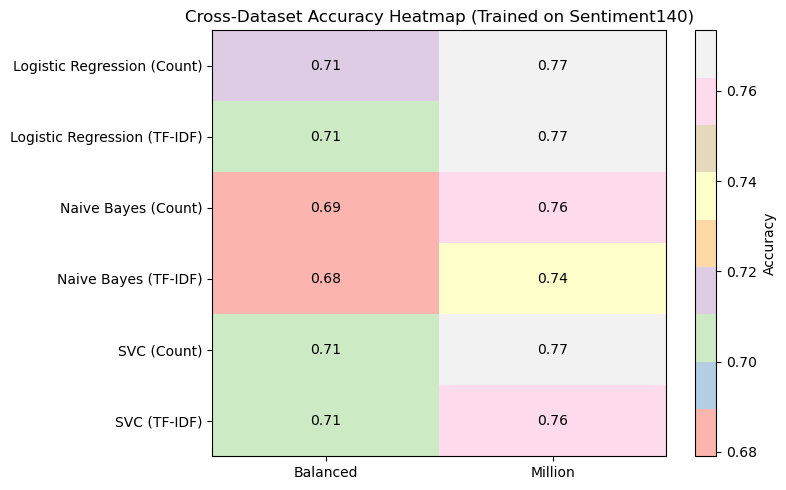

In [17]:

plt.figure(figsize=(8, 5))
plt.imshow(matrix_results, cmap='Pastel1', aspect='auto')

plt.xticks(range(len(matrix_results.columns)), matrix_results.columns)
plt.yticks(range(len(matrix_results.index)), matrix_results.index)

# Annotate accuracy values
for i in range(len(matrix_results.index)):
    for j in range(len(matrix_results.columns)):
        value = matrix_results.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

plt.title("Cross-Dataset Accuracy Heatmap (Trained on Sentiment140)")
plt.colorbar(label="Accuracy")
plt.tight_layout()
plt.savefig("cross_dataset_accuracy_heatmap.png")
plt.show()

### **Cross-Dataset Accuracy Analysis (Trained on Sentiment140)**

The heatmap illustrates how different combinations of machine learning models and vectorizers perform when trained on the **Sentiment140** dataset and tested on two distinct datasets: **Balanced** and **Million**. Overall, accuracy scores range between **0.68 and 0.77**, indicating moderate generalization across domains. A clear pattern emerges: all models achieve **higher accuracy on the Million dataset (≈0.74–0.77)** compared to the Balanced dataset (≈0.68–0.71). This suggests that the Million dataset is more linguistically or structurally aligned with Sentiment140, while the Balanced dataset likely contains domain shifts — possibly due to variations in slang, content style, or noise level.

**Model comparison** reveals that **Logistic Regression and SVC (Support Vector Classifier)** consistently outperform **Naive Bayes**, regardless of vectorization method. Both Logistic Regression and SVC attain **0.77 accuracy** on the Million dataset and around **0.71 accuracy** on the Balanced dataset, demonstrating strong robustness across domains. In contrast, Naive Bayes lags behind, particularly with TF-IDF, reaching only **0.68 accuracy** on Balanced data. This indicates that Naive Bayes is more sensitive to vocabulary distribution shifts, whereas linear models handle cross-domain variation better.

**Vectorizer impact** (Count vs TF-IDF) is minimal for Logistic Regression and SVC, showing nearly identical performance. However, for Naive Bayes, the **Count Vectorizer performs slightly better** than TF-IDF, particularly on Balanced data (0.69 vs 0.68). This suggests that word frequency representation aligns better with Naive Bayes’ probabilistic assumptions than TF-IDF weighting.

---

#### **Accuracy Summary Table**

The table below (from the heatmap) summarizes accuracy scores for each model–vectorizer combination across datasets:

- **Rows:** Models with vectorization type  
- **Columns:** Target datasets (Balanced, Million)  
- **Cell Values:** Accuracy scores (e.g., 0.71 = 71% accuracy)  

Key highlights:  
- Best overall performance: Logistic Regression (Count/TF-IDF) and SVC (Count) with **0.77 accuracy** on Million dataset.  
- Lowest performance: Naive Bayes (TF-IDF) on Balanced dataset with **0.68 accuracy**.

---

**Implications for modeling:**  
- **Preferred models:** Logistic Regression and SVC are reliable choices for cross-domain sentiment tasks.  
- **Dataset sensitivity:** Balanced dataset requires additional preprocessing or domain adaptation to close the accuracy gap.  
- **Feature choice:** Count Vectorizer suffices; TF-IDF offers no clear advantage for linear models but may underperform with Naive Bayes.



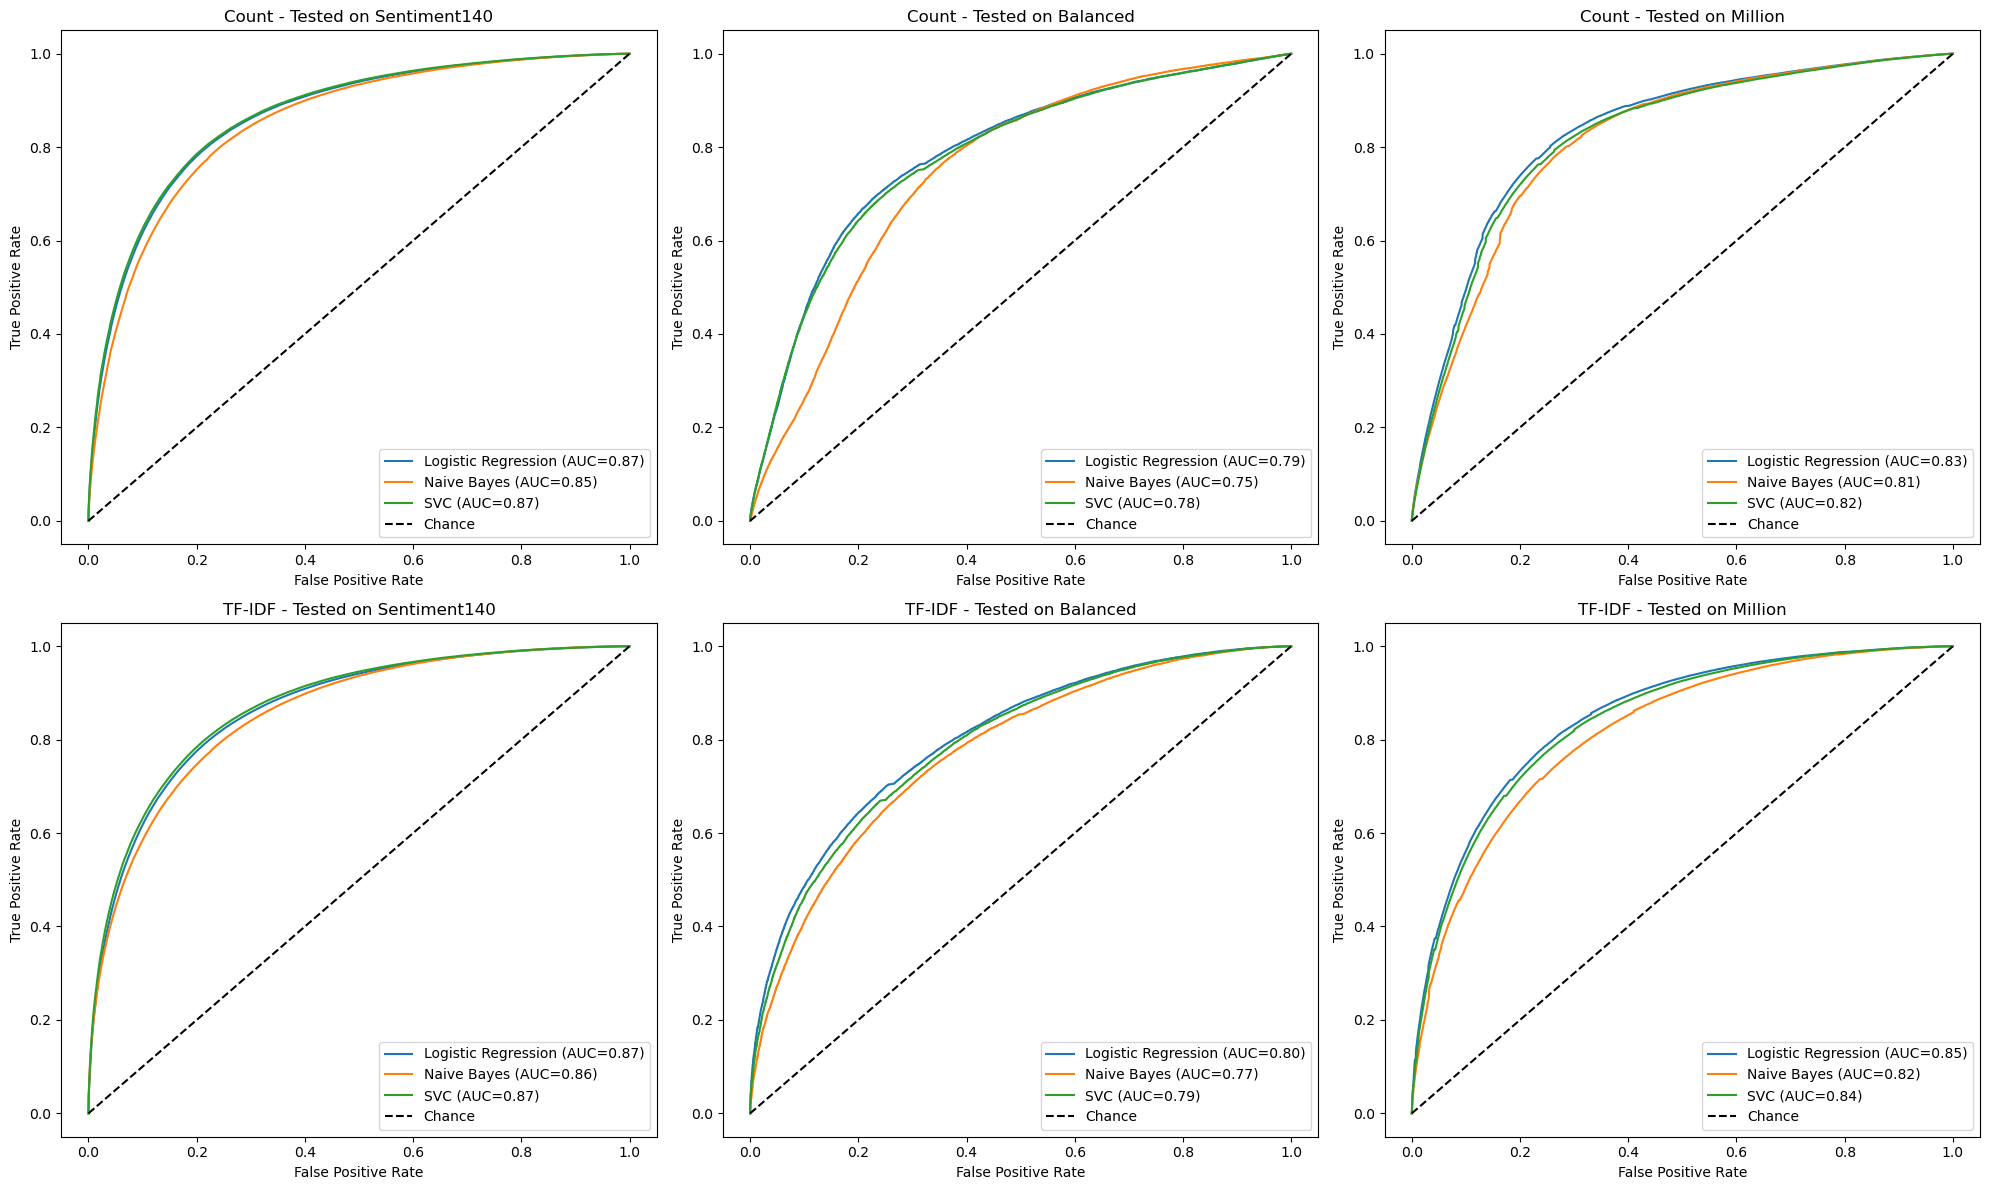

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

def plot_roc_auc_2x3(models, vectorizers, datasets_cleaned):
    """
    Plots ROC curves for all models (Logistic, NB, SVC) on 2x3 grid:
    - Row 1: Count Vectorizer
    - Row 2: TF-IDF
    Columns: Sentiment140 (train) tested on Sentiment140, Balanced, Million
    """

    # -------------------
    # 1. Prepare data splits (train on Sentiment140, test on Balanced/Million/Sentiment140)
    # -------------------
    train_df = datasets_cleaned["Sentiment140"]
    X_train = train_df["Cleaned text"]
    y_train = train_df["target"]

    test_sets = {
        "Sentiment140": datasets_cleaned["Sentiment140"],
        "Balanced": datasets_cleaned["Balanced"],
        "Million": datasets_cleaned["Million"]
    }

    # -------------------
    # 2. Setup Plot (2 rows: Count, TF-IDF) and 3 columns (datasets)
    # -------------------
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    for row_idx, (vec_name, vectorizer) in enumerate(vectorizers.items()):
        # Vectorize training data
        X_train_vec = vectorizer.fit_transform(X_train)

        # Train each model on Sentiment140
        trained_models = {}
        for model_name, model in models.items():
            # Handle SVC with calibration for probabilities
            if model_name == "SVC":
                model = LinearSVC(max_iter=5000)
                model = CalibratedClassifierCV(model, method='sigmoid', cv=5)

            model.fit(X_train_vec, y_train)
            trained_models[model_name] = model

        # Test on each dataset and plot ROC
        for col_idx, (test_name, test_df) in enumerate(test_sets.items()):
            ax = axes[row_idx, col_idx]

            X_test = test_df["Cleaned text"]
            y_test = test_df["target"]

            # Vectorize test data
            X_test_vec = vectorizer.transform(X_test)

            # Plot ROC for each model
            for model_name, trained_model in trained_models.items():
                # Get scores
                if hasattr(trained_model, "predict_proba"):
                    y_score = trained_model.predict_proba(X_test_vec)[:, 1]
                else:
                    y_score = trained_model.decision_function(X_test_vec)

                # Compute ROC and AUC
                fpr, tpr, _ = roc_curve(y_test, y_score)
                roc_auc = auc(fpr, tpr)

                # Plot
                ax.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")

            # Add baseline and titles
            ax.plot([0, 1], [0, 1], 'k--', label='Chance')
            ax.set_title(f"{vec_name} - Tested on {test_name}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function
plot_roc_auc_2x3(models, vectorizers, datasets_cleaned)


### **ROC/AUC Comparison Across Vectorizers and Datasets**

#### **Purpose**
- Evaluate how well models trained on **Sentiment140** generalize to **Sentiment140, Balanced, and Million** datasets.
- Compare **Count vs TF-IDF vectorization** and assess **model ranking performance** beyond simple accuracy.

---

#### **Key Observations from the Chart**

1. **Sentiment140 (Train/Test on Same Dataset)**
   - Both Count and TF-IDF yield **highest AUC ≈ 0.87** for Logistic Regression and SVC.
   - Naive Bayes trails slightly but still performs well (AUC ≈ 0.85–0.86).
   - Minimal difference between Count and TF-IDF, indicating robust vocabulary representation.

2. **Balanced Dataset (Cross-Dataset Evaluation)**
   - AUC drops to **≈0.79 for Logistic Regression/SVC** and **≈0.75–0.77 for Naive Bayes**.
   - Indicates **domain shift** — Balanced dataset likely has different linguistic patterns or fewer sentiment cues.
   - TF-IDF provides a slight boost over Count (0.80 vs 0.79).

3. **Million Dataset (Cross-Dataset Evaluation)**
   - AUC remains strong: **≈0.83–0.85 for Logistic Regression**, **≈0.82–0.84 for SVC**, and **≈0.81–0.82 for Naive Bayes**.
   - Performance gap between Count and TF-IDF is minimal (≈0.01–0.02).

4. **Model Ranking**
   - **Logistic Regression consistently leads** across all datasets and vectorizations.
   - **SVC closely follows** with similar AUC trends.
   - **Naive Bayes underperforms slightly**, especially on Balanced dataset.

---

#### **Insights**
- **High AUC on Sentiment140** shows strong model fit but also potential overfitting to training distribution.
- **Balanced dataset’s lower AUC** highlights the impact of domain differences; additional preprocessing or domain adaptation could help.
- **Million dataset shows better generalization** than Balanced, suggesting greater similarity to Sentiment140 in vocabulary and structure.
- **Vectorizer impact is minor**, with TF-IDF providing slight gains on Balanced and Million datasets.
- **Logistic Regression and SVC are preferred models** for cross-dataset sentiment tasks; Naive Bayes is less reliable but still competitive given simplicity.

---

#### **Recommendation**
- Use **Logistic Regression or SVC with TF-IDF** as default for cross-domain scenarios.
- Investigate **domain adaptation** or **fine-tuning with mixed datasets** to close performance gaps on Balanced dataset.
- Include **additional metrics (precision/recall/F1)** to confirm class-level stability alongside ROC/AUC.


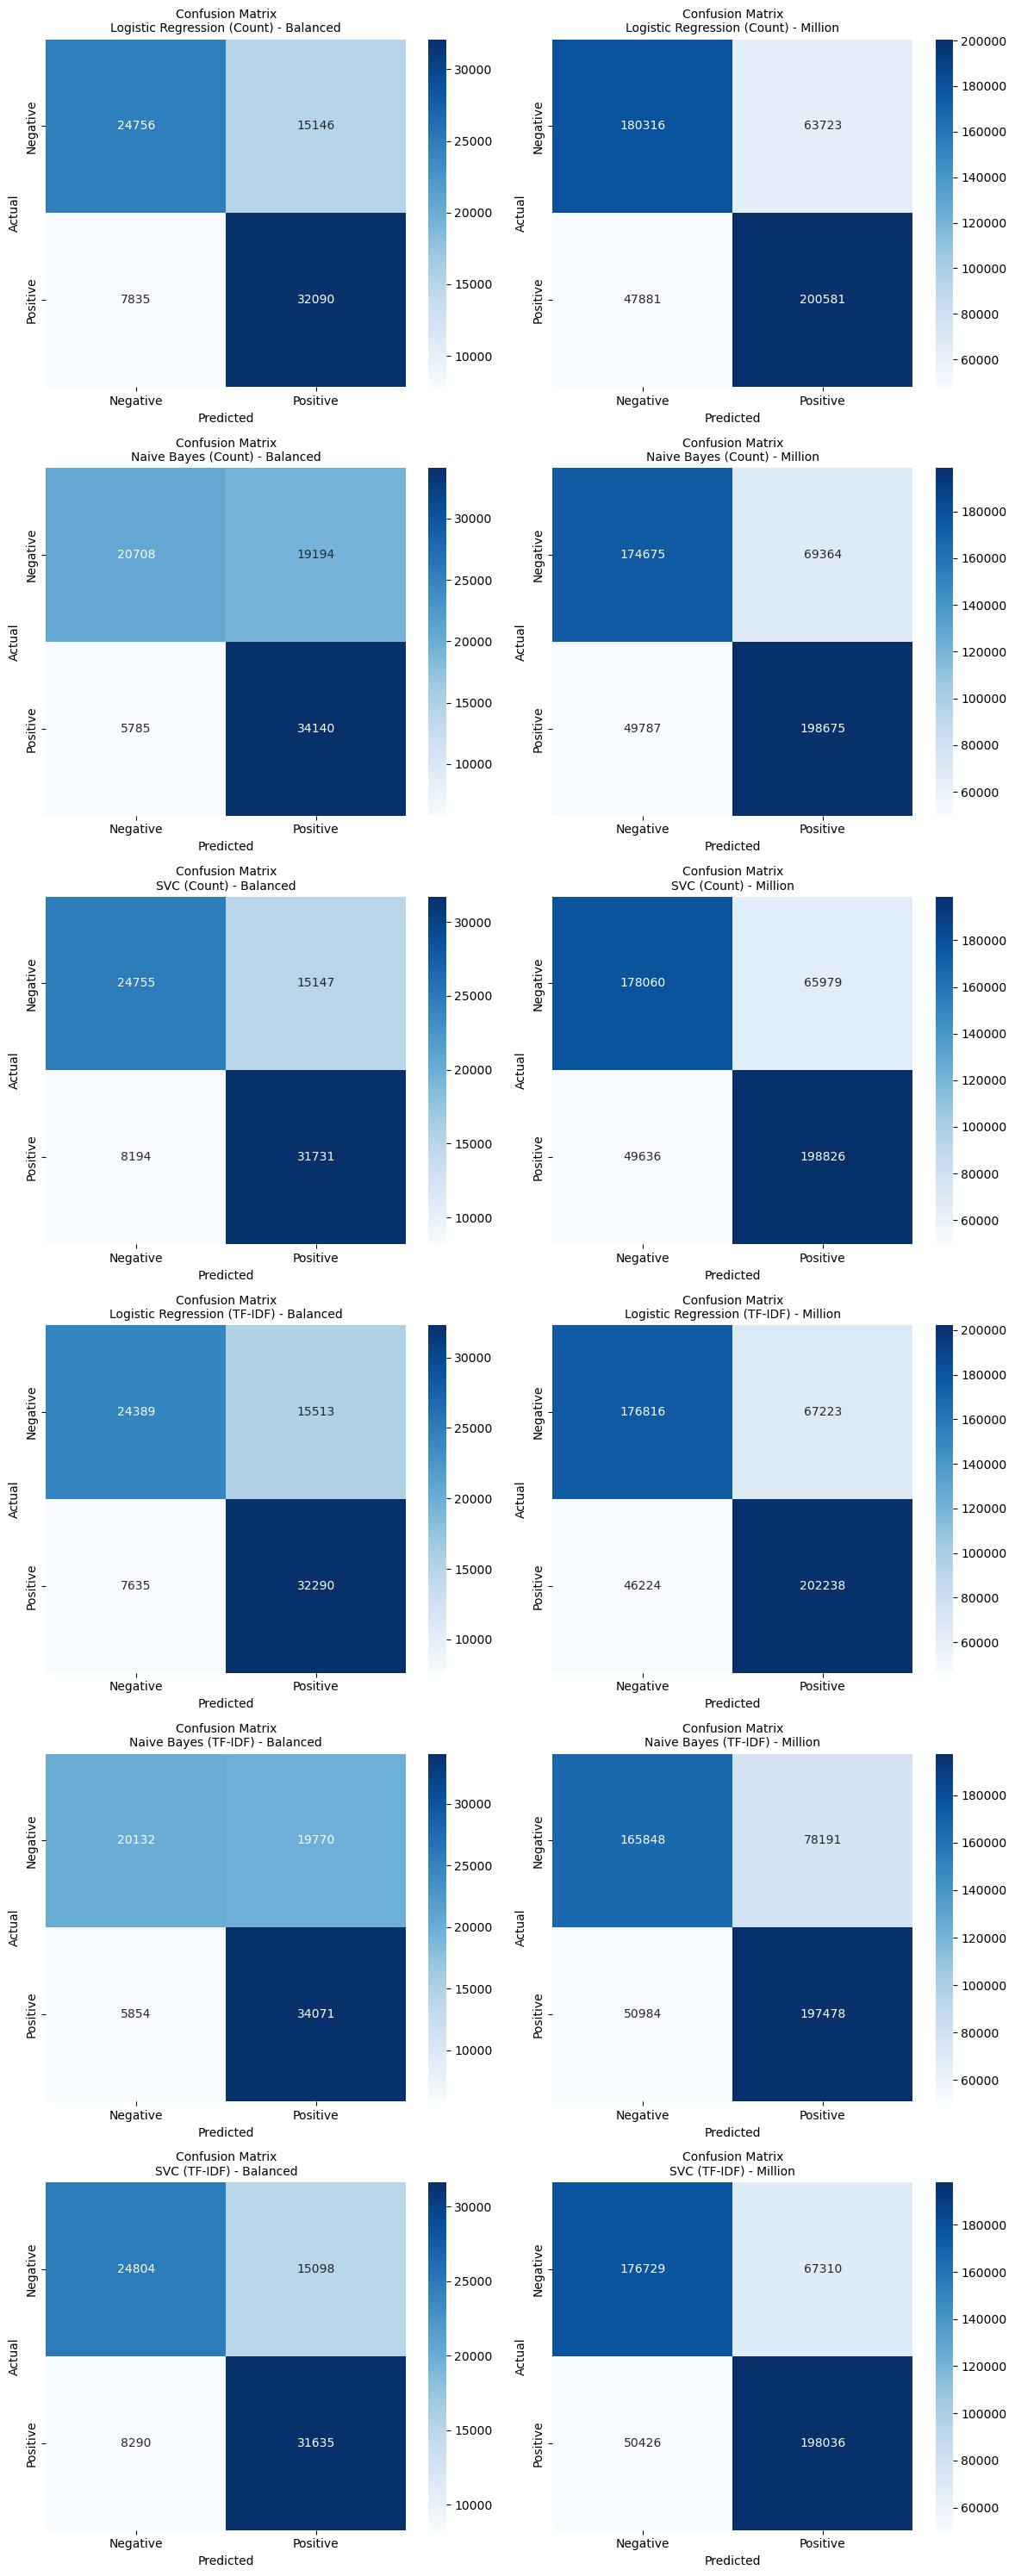

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust number of plots based on how many models you tested
n = len(conf_matrices)
cols = 2  # Number of columns of plots
rows = (n // cols) + (n % cols > 0)

plt.figure(figsize=(12, 5 * rows))  # Adjust size as needed

for i, (label, cm) in enumerate(conf_matrices.items(), 1):
    plt.subplot(rows, cols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix\n{label}", fontsize=10)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


### **Conclusion**

The cross-dataset evaluation shows that models trained on **Sentiment140** generalize fairly well to the **Million** dataset, achieving accuracies up to **0.77**. This consistency suggests strong alignment between these two datasets in terms of sentiment-laden vocabulary and linguistic patterns. Conversely, the **Balanced** dataset records lower accuracies (≈0.68–0.71), reflecting significant domain differences, possibly due to unique slang, informal expressions, or distribution shifts in its data.  

**Logistic Regression** and **SVC** consistently outperform **Naive Bayes**, indicating that linear classifiers are better suited to high-dimensional sparse text data. Naive Bayes, particularly with TF-IDF features, struggles with cross-domain generalization, underscoring its reliance on consistent feature distributions. Interestingly, **Count Vectorizer and TF-IDF** perform nearly identically for Logistic Regression and SVC, suggesting that simple word frequency features suffice for these models, while Count slightly favors Naive Bayes.  

Dataset quality plays a crucial role in these results: **Sentiment140** and **Million** are large-scale, relatively balanced, and contain abundant sentiment indicators, while **Balanced** appears smaller, noisier, and less representative, leading to reduced accuracy. Further cleaning or balancing of this dataset could improve model transferability and reduce domain-specific biases.  

These findings highlight the importance of **choosing robust models and assessing dataset quality** in cross-domain tasks. Incorporating domain adaptation techniques or leveraging pre-trained embeddings (Word2Vec, GloVe, Transformer-based models) could further enhance generalization. Future evaluations should also include **precision, recall, and F1-scores** to uncover class-level nuances beyond accuracy.  

Overall, **Logistic Regression and SVC with either Count or TF-IDF** emerge as reliable baselines for sentiment analysis across multiple datasets, provided data quality and preprocessing are carefully managed.


## Test The Model

In [49]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    """
    Clean and preprocess a single text input:
    - Lowercase
    - Remove URLs, mentions, hashtags, digits, punctuation
    - Remove extra whitespace
    """
    text = text.lower()
    text = re.sub(r"http\S+", "", text)      # Remove URLs
    text = re.sub(r"@\w+", "", text)         # Remove mentions
    text = re.sub(r"#\w+", "", text)         # Remove hashtags
    text = re.sub(r'\b[a-zA-Z]\b', '', text) # Remove single characters (like s, t, m)
    text = text.replace("n't", " not").replace("'re", " are").replace("'m", " am").replace("'s", " is")
    text = re.sub(r'[^a-z\s]', '', text)     # Remove punctuation/numbers
    tokens = re.findall(r"\b\w+\b", text)
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)
    return text


In [50]:
label_map = {0: "Negative", 1: "Positive"}

def predict_sentiment(review, pipeline):
    cleaned_review = preprocess_text(review)
    prediction = pipeline.predict([cleaned_review])[0]
    print(f"\nCleaned Review: {cleaned_review}")
    print(f"Predicted Sentiment: {label_map[prediction]}")
    print("-" * 50)


In [52]:
print("Test :\n")

while True:
    print("Enter your review below (type -1 to exit):\n")
    user_input = input("Review: ")
    if user_input.strip() == "-1":
        print("Exited sentiment tester.")
        break
    elif user_input.strip() == "":
        print("Please enter a valid review.")
        continue
    predict_sentiment(user_input, pipeline)

Test :

Enter your review below (type -1 to exit):



Review:  Case was fine but it didnt protect my phone. Was on my bike and as I got off, I dropped my phone. Whole back screen in now cracked. Looks are fine but protection...not so much.



Cleaned Review: case fine didnt protect phone bike got dropped phone screen cracked look fine protectionnot
Predicted Sentiment: Negative
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  It was a very lovely product, especially because of its beautiful and high-quality appearance. It fit the phone very well, was very comfortable, and was manufactured with great care and elegance. One of its most important features is the stand that holds the phone in different positions, and I have to say that it works well and can be trusted.



Cleaned Review: lovely product especially beautiful highquality appearance fit phone comfortable manufactured great care elegance important feature stand hold phone different position say work trusted
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Great inexpensive case. Bulletproof.



Cleaned Review: great inexpensive case bulletproof
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Sick the phone sticks to the car.



Cleaned Review: sick phone stick car
Predicted Sentiment: Negative
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Thin and protective



Cleaned Review: protective
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Really good case. Kick stand doesn't work best in the horizontal position, great vertically however.



Cleaned Review: really good case kick stand doesn work best horizontal position great vertically
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Seems to be working. Haven't dropped the phone yet to test the case! Button all seem to work. The rear stand thing works well too.



Cleaned Review: working haven dropped phone test case button work rear stand thing work
Predicted Sentiment: Negative
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Terrific case and well-designed. Magnet that becomes like a built-in pop socket. Only thing I would change would be if it had cut outs for each individual camera lens.



Cleaned Review: terrific case welldesigned magnet like builtin pop socket thing change cut out individual camera lens
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  The perfect design but with a problem. The pen works with some mistake.



Cleaned Review: perfect design problem pen work mistake
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Case is made of a hard plastic however I feel it wouldn't be sufficient to prevent accidentally drops or dings. The back concerns me more because it's thinner and I think that needs to be slightly thicker. A case protector needs to have protection all around.



Cleaned Review: case hard plastic feel wouldn sufficient prevent accidentally drop ding concern thinner think need slightly thicker case protector need protection
Predicted Sentiment: Negative
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Case was fine but it didnt protect my phone. Was on my bike and as I got off, I dropped my phone. Whole back screen in now cracked. Looks are fine but protection...not so much.



Cleaned Review: case fine didnt protect phone bike got dropped phone screen cracked look fine protectionnot
Predicted Sentiment: Negative
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Guys, the case looks great and good quality, but my spen doesn't work with the case because of magnets on the back. Removing the case the spen works fine. Make sure you test it if you have already bought it. 5 people found this helpful



Cleaned Review: guy case look great good quality spen doesn work case magnet removing case spen work fine make sure test bought people helpful
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  Guys, the case looks great and good quality, but my spen doesn't work with the case because of magnets on the back. Removing the case the spen works fine. Make sure you test it if you have already bought it.



Cleaned Review: guy case look great good quality spen doesn work case magnet removing case spen work fine make sure test bought
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  I got the dessert-colored case. It is sturdy, but it gets dirty very easily. Even with alcohol wiping multiple times, the "dirt" stuck to the plastic and could not be removed. Ruin my S25 Ultra look. DO NOT GET this colour. It is also heavy



Cleaned Review: got dessertcolored case sturdy get dirty easily alcohol wiping multiple time dirt stuck plastic removed ruin s ultra look colour heavy
Predicted Sentiment: Negative
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  DO NOT BUY IT!  This case does not fit with any screen protectors, specifically the camera protector.  The product is not as high quality as they describe it here.  I'm going to return it as I found much better quality with great functionality with the same price.  If you can get another one, avoid the headache.



Cleaned Review: buy case doe fit screen protector specifically camera protector product high quality going return better quality great functionality price avoid headache
Predicted Sentiment: Positive
--------------------------------------------------
Enter your review below (type -1 to exit):



Review:  -1


Exited sentiment tester.
